# Image Restoration - deblurring

## In this notebook I will show how to filter a blurred image in order to restore the initial data. I will use a simulation of granular structure (from SOPHISM simulations) that is free from optical aberrations and noise.

In [290]:
import WF_psf_mtf
from WF_psf_mtf import *


In [291]:
p = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/MTF/'
data = pyfits.getdata(p+'Masi_hrt.fits')
data = data[300:600,300:600]

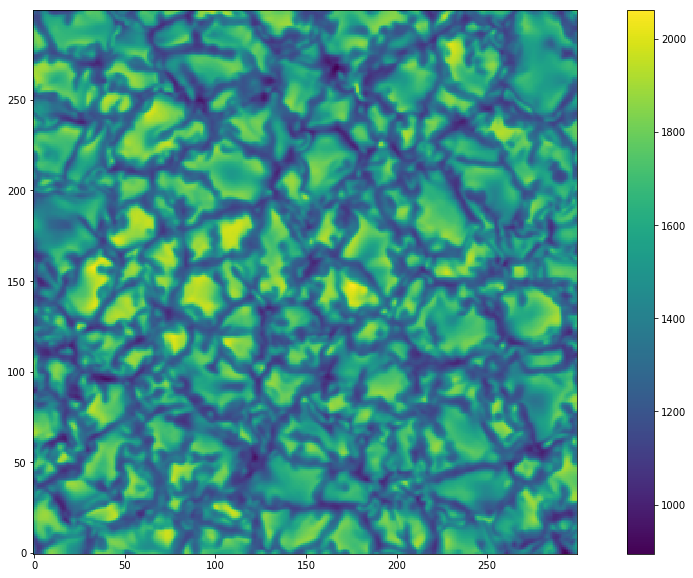

In [3]:
plt.figure(figsize=(18,10))
plt.imshow(data,origin='lower')
plt.colorbar()

## OTF synthesis
### We will synthesis a wavefront aberration consisting of defocus and astigmatism

In [293]:
D = 140 #diameter of the aperture
lam = 617.3*10**(-6) #wavelength of observation
pix = 0.5 #plate scale
f = 4125.3            #effective focal length      
size = data.shape[0] #size of detector in pixels

In [294]:
coefficients = np.zeros(8)
coefficients[0] = 0
coefficients[1] = 0
coefficients[2] =0
coefficients[3] = 0.5
coefficients[4] = 0.1
coefficients[5] = 0.4
coefficients[6] = 0
coefficients[7] = 0

In [295]:
rpupil = pupil_size(D,lam,pix,size)
sim_phase = center(coefficients,size,rpupil)
Mask = mask(rpupil, size)


pupil_com = complex_pupil(sim_phase,Mask)
psf = PSF(pupil_com)
otf = OTF(psf)
mtf = MTF(otf)

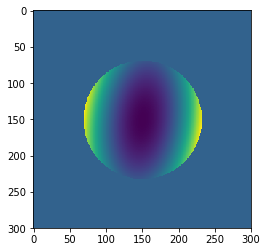

In [296]:
plt.imshow(sim_phase)

# No noise
### I will produce the aberrated data without adding any noise

In [297]:
fft_image = np.fft.fft2(data)
temp = fft_image*otf
defoc = np.fft.ifft2(temp).real


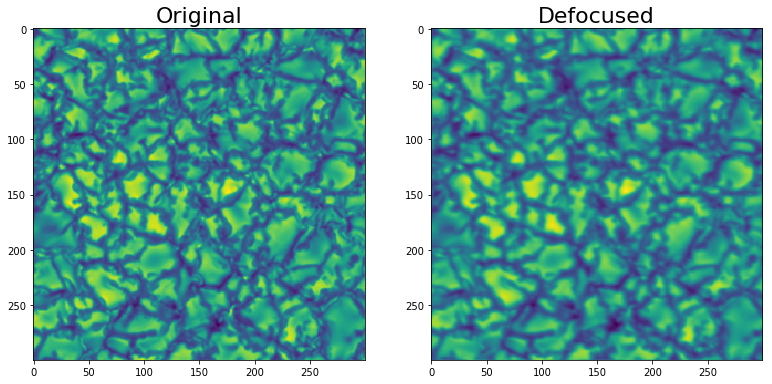

In [298]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121,aspect='equal')
ax2 = fig.add_subplot(122,aspect='equal')
im=ax.imshow(data)
im2=ax2.imshow(defoc)
fig.subplots_adjust(right=0.8)
ax.set_title('Original',fontsize=22)
ax2.set_title('Defocused',fontsize=22)

### To restore the initial scene we could use the inverse filtering, which is dividing the blurred scene with the synthesized OTF, then using the inverse Fourier Transform:

In [299]:
fft_blurred = fft2(defoc)
restored = fft_blurred/otf
restored = ifft2(restored).real

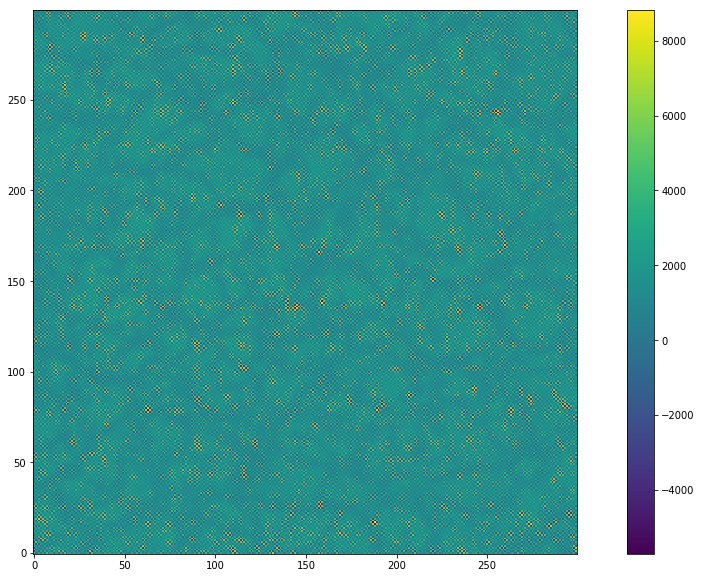

In [300]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### So what happened? why does the restored scene look so noisy? To understand this let's look at the MTF:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


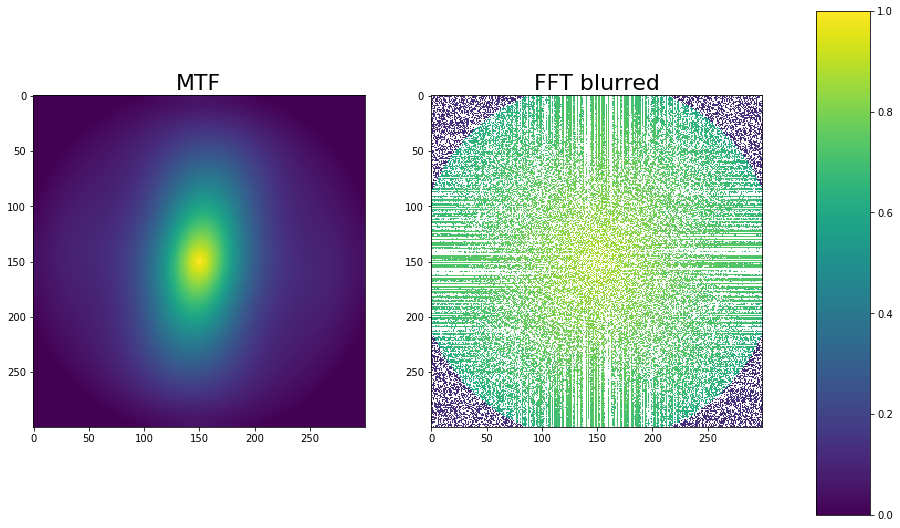

In [301]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121,aspect='equal')
ax2 = fig.add_subplot(122,aspect='equal')
im=ax.imshow(fftshift(mtf))
im2=ax2.imshow(np.log(fftshift(fft_blurred).real))
fig.subplots_adjust(right=0.8)
ax.set_title('MTF',fontsize=22)
ax2.set_title('FFT blurred',fontsize=22)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### As expected, the high frequencies have zero signals in the OTF, which makes sense since the convolution with a PSF (xOTF) will lower the spatial resolution of the image which acts at the samllest spatial scales, i.e. the highest frequencies, and we know that in the 2D FT of a 2D image, the high frequency content lies away from the center.


# The Wiener Filter

### So the division with zero signals at high frequencies is amplifying the noise, and the result is a noisy restored image. One way to solve this is to use the <a href='https://de.wikipedia.org/wiki/Wiener-Filter'>Wiener Filter</a> with setting a value to the constant K.

In [42]:
K = 1e-3
W = np.conj(otf)/(np.abs(otf)**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

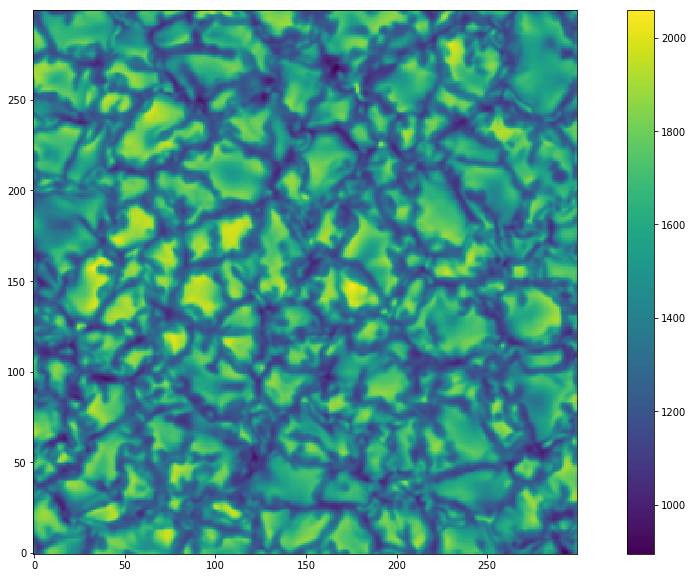

In [43]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### The constant K is related to the inverse of the signal to noise ratio of the image.

# Add noise

### Now we will blur the simulation with adding white (Gaussian) noise and then try to recover the intial data. The amount of noise is related to the signal to noise ratio we would like to have.

In [141]:
mean=0
SNR = 300
sigma = data.std()/np.sqrt(SNR)
gaussian =np.random.normal(mean,scale=sigma,size =(size,size))

In [142]:
fft_image = np.fft.fft2(data)
temp = fft_image*otf + fft2(gaussian)
defoc = np.fft.ifft2(temp).real


### Since we know the SNR we know that the K parameter should be the inverse of the SNR

In [200]:
K = 1./SNR
fft_blurred = fft2(defoc)
W = np.conj(otf)/((np.abs(otf))**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

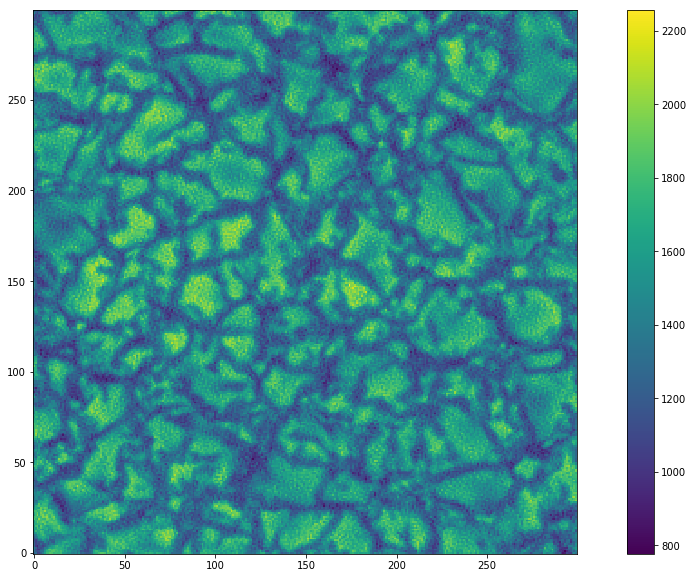

In [202]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### you can see that the restored image still looks noisy, experimenting with the value of K, you can see that the higher this parameter is, the less noisy the restored image is but on the expense of the spatial resolution. Let's set K to 0.1

In [272]:
K = 0.1
fft_blurred = fft2(defoc)
W = np.conj(otf)/(np.abs(otf)**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

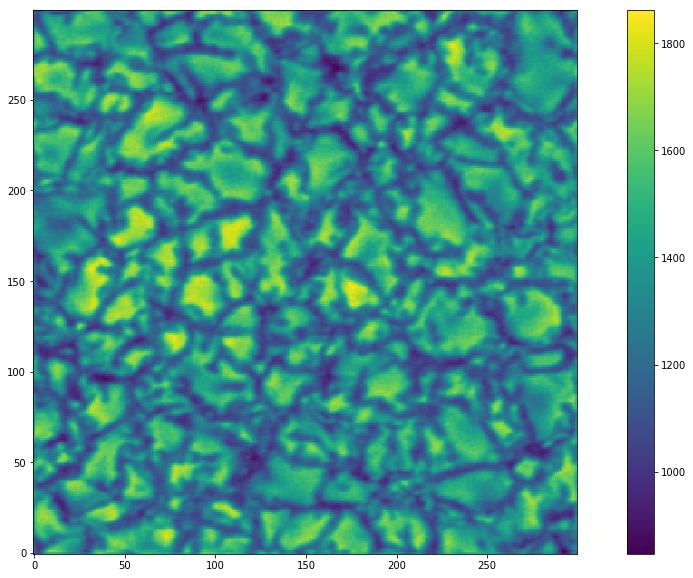

In [273]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### you can see now how the image is much less noisy but the quality of the image is lowerd. That is because both noise and resolution belong to the high frequency content of the image, and one has to decide which one is to be compromised.

# Cutoff frequency Mask

### We could instead of using a parameter K, use a cutoff frequency filter that is multiplied with the FFT of the blurred image to block frequencies above a certain threshold.

In [274]:
def noise_mask_high(size,cut_off):
   X = np.linspace(-0.5,0.5,size)
   x,y = np.meshgrid(X,X)
   mask = np.zeros((size,size))
   m = x * x + y * y <= cut_off**2
   mask[m] = 1
   return mask

### Since the Nyquisit frequency of the system is 0.5 cyc/pixel, and it is the cutoff frequency of the modulation transfer function (we cannot resolve features above this frequency), it corresponds to the resolution of our system. Let us take this value as the cutoff for making the mask (and setting the parameter K to zero), if the plate scale of our telescope is 0.5"/pixel, then this filter will block signals from features having size of less than 1 arcsec.

In [277]:
M = fftshift(noise_mask_high(size,0.5))
K = 0#1./SNR
fft_blurred =M*fft2(defoc)
W = np.conj(otf)/(np.abs(otf)**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

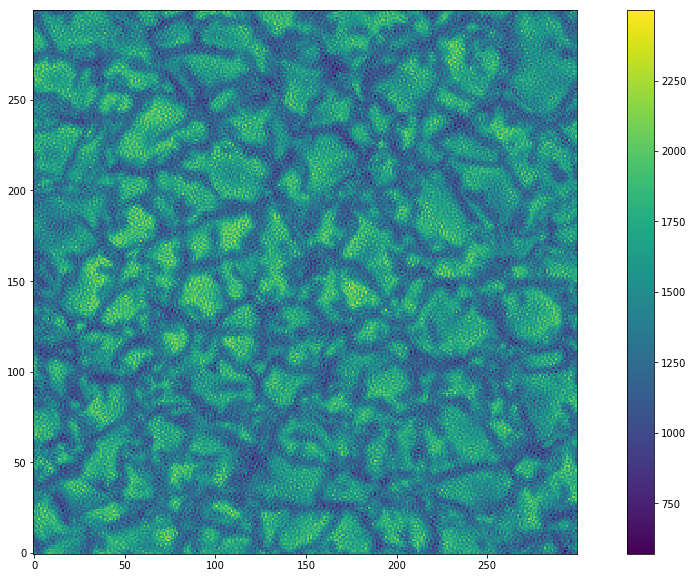

In [278]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### you can see that the image is noisy. If we take a lower threshold, meaning that we are blocking more frequencies:

In [285]:
M = fftshift(noise_mask_high(size,0.2))
K = 0#1./SNR
fft_blurred =M*fft2(defoc)
W = np.conj(otf)/(np.abs(otf)**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

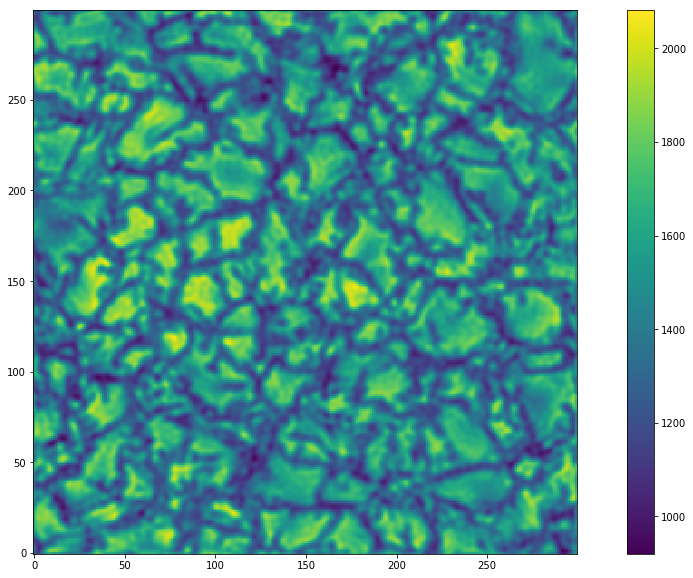

In [286]:
plt.figure(figsize=(18,10))
plt.imshow(restored,origin='lower')
plt.colorbar()

### you can see that we are lowering the quality of the image due to the exclusion of more high frequency components. After testing different values and inspecting the quality of the image, taking a cutoff frequency corresponding to the half of the resolution (0.25 cyc/pixel) turned out to be the best solution.

In [287]:
M = fftshift(noise_mask_high(size,0.25))
K = 0#1./SNR
fft_blurred =M*fft2(defoc)
W = np.conj(otf)/(np.abs(otf)**2+K)
restored = W*fft_blurred
restored = ifft2(restored).real

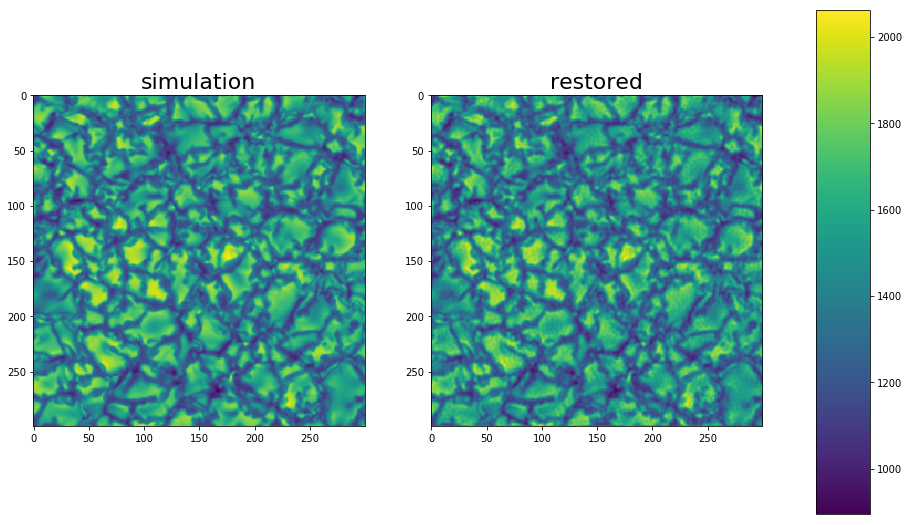

In [289]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121,aspect='equal')
ax2 = fig.add_subplot(122,aspect='equal')
im=ax.imshow(data)
im2=ax2.imshow(restored)
fig.subplots_adjust(right=0.8)
ax.set_title('simulation',fontsize=22)
ax2.set_title('restored',fontsize=22)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### So using the cutoff filter is in a way similar to using the parametrized form of the Wiener filter. Since the filter is simply the inverse filter if the OTF is higher than the parameter value (which also translates to the frequency being lower than a certain cutoff) and zero if OTF is lower than the parameter value (equivalent to the frequency being higher than the cutoff).